# Advanced Lane Lines Project



## Camera Calibration 

This is the routine to calibrate de camera.

In [152]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        """cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()"""

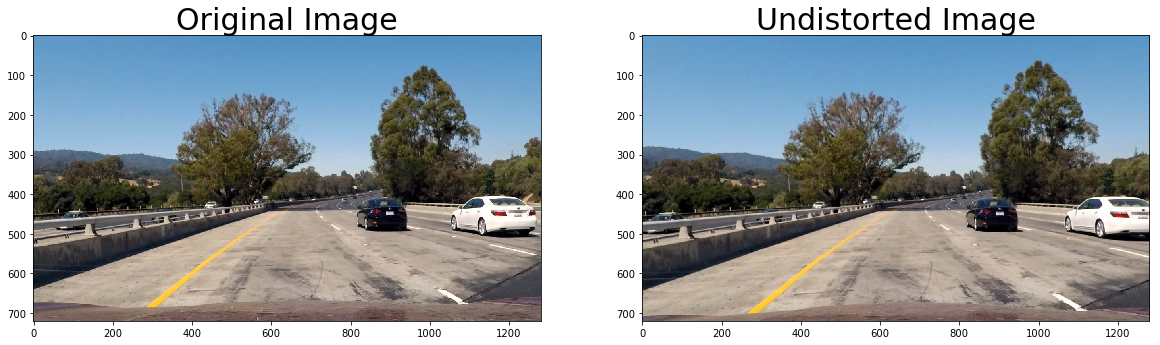

In [153]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('test_images/test1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

def undist(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx) 
    return dst


dst = undist(img)
cv2.imwrite('test_images/test1_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
"""dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )"""

dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)




# Bird View Transform 

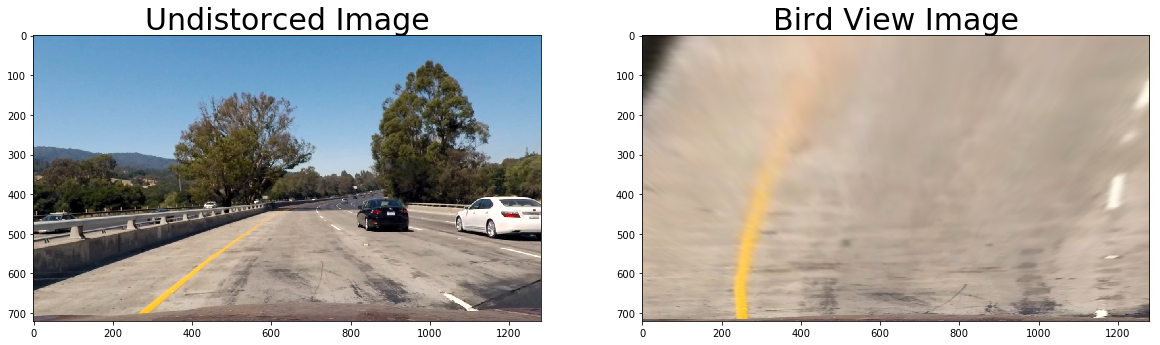

In [128]:
img_size=(dst.shape[1],dst.shape[0])
src_pts = np.float32([[245,720],[590,450],[685,450],[1060,720]])
dst_pts = np.float32([[245,720],[245,0],[1060,0],[1060,720]])
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warped = cv2.warpPerspective(dst, M, img_size, flags=cv2.INTER_LINEAR)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(dst)
ax1.set_title('Undistorced Image', fontsize=30)
ax2.imshow(warped)
ax2.set_title('Bird View Image', fontsize=30)



## Sobel Operator

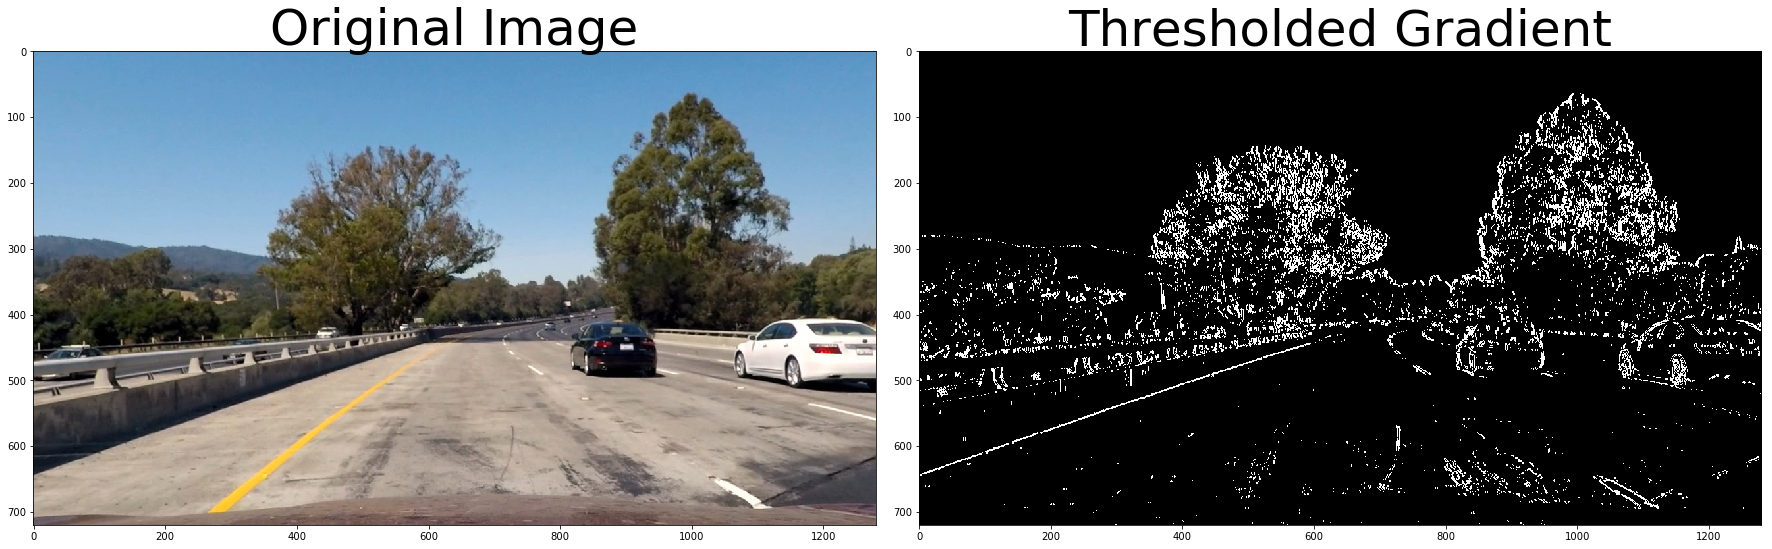

In [32]:
import matplotlib.image as mpimg

image = mpimg.imread('test_images/test1_undist.jpg')

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Run the function
grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Magnitude Gradient 

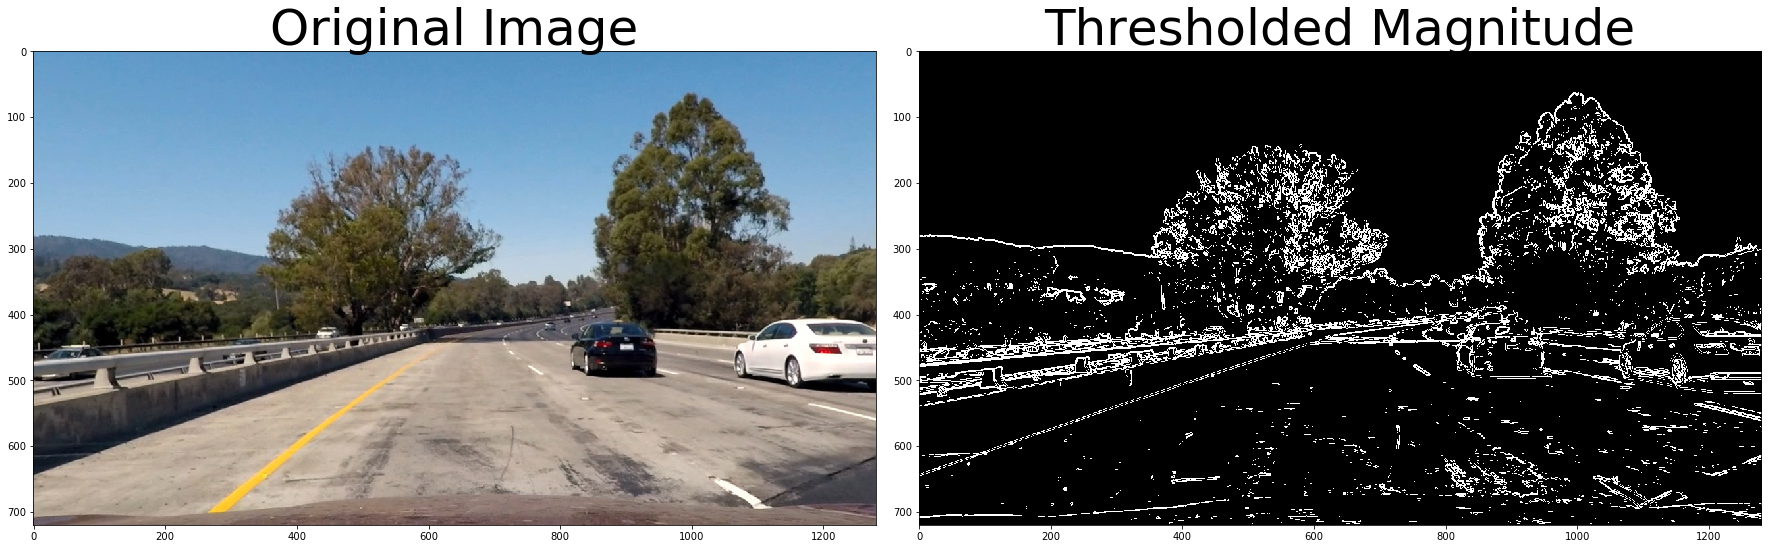

In [33]:
import matplotlib.image as mpimg

image = mpimg.imread('test_images/test1_undist.jpg')

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Run the function
grad_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Direction of the Gradient

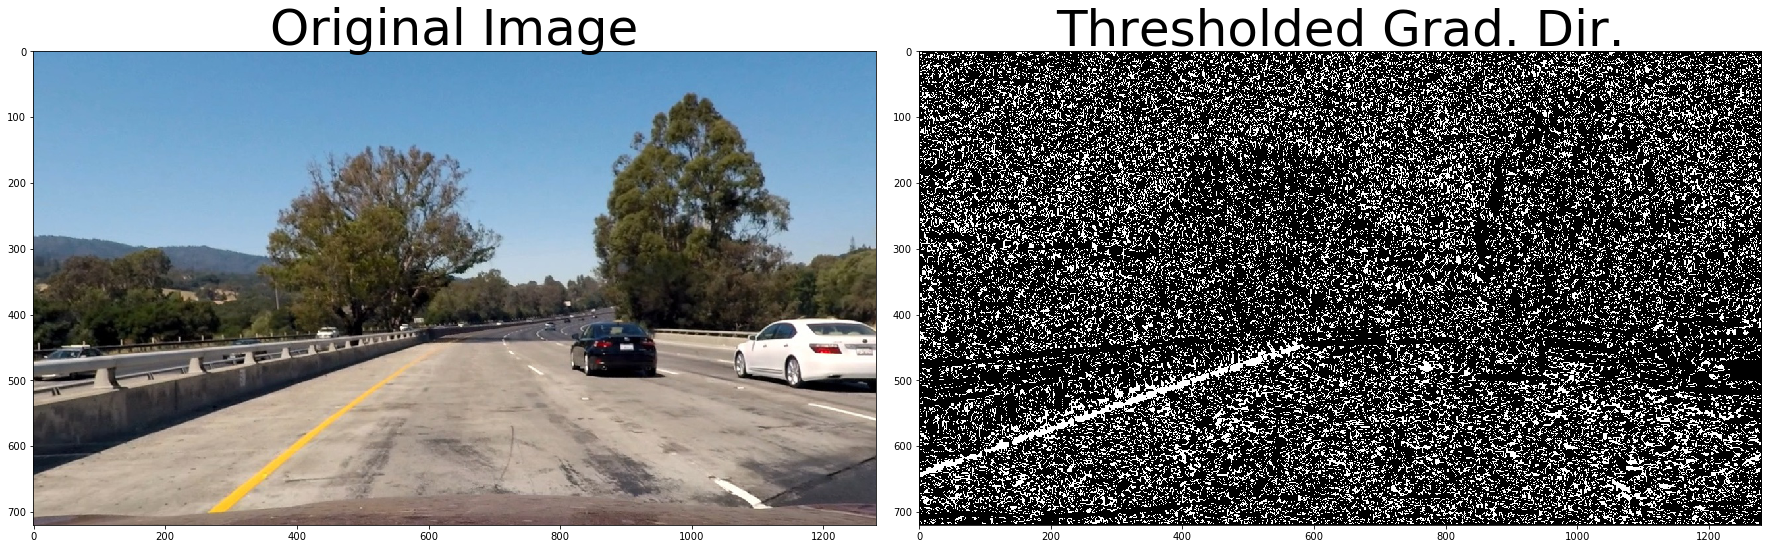

In [34]:
# Read in an image
image = mpimg.imread('test_images/test1_undist.jpg')

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(1.0, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Experiments with diferents thresholds combinations 

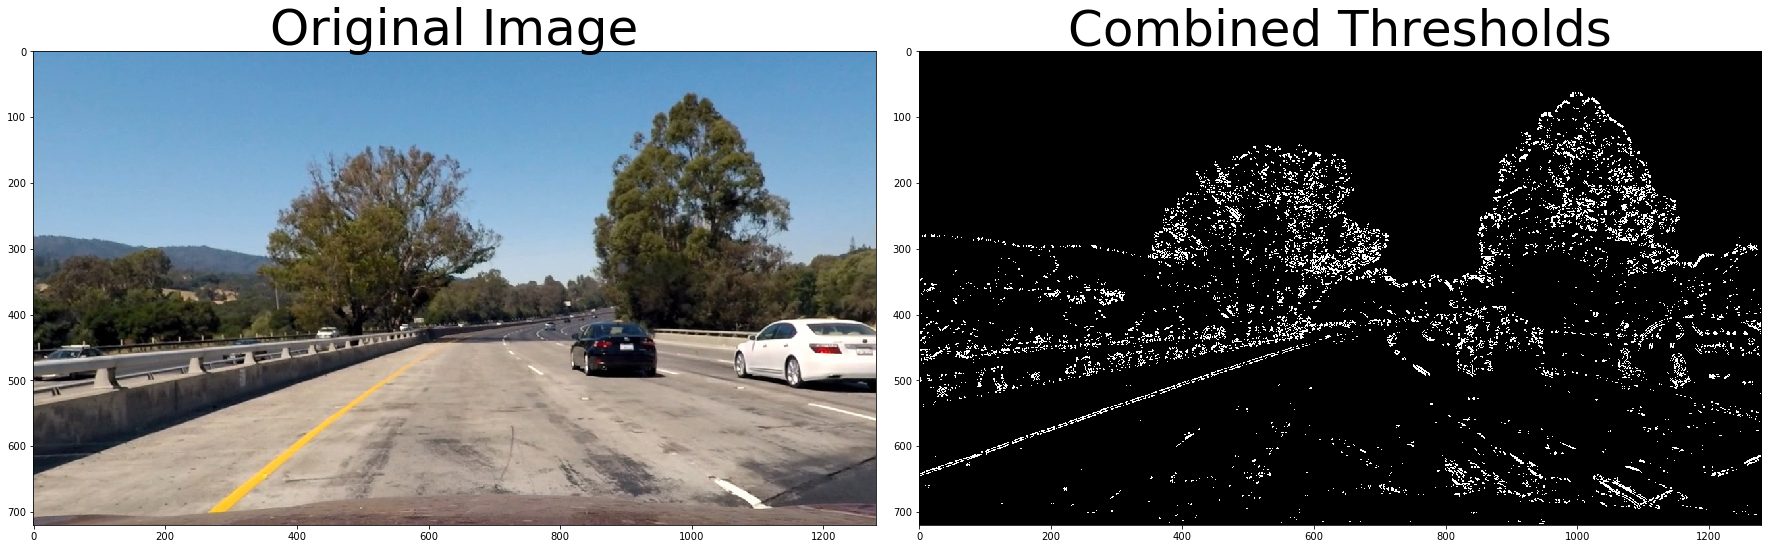

In [41]:
image = mpimg.imread('test_images/test1_undist.jpg')

# Choose a Sobel kernel size
ksize = 7 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
grady = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Thresholds', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)




## Color Space Tests 

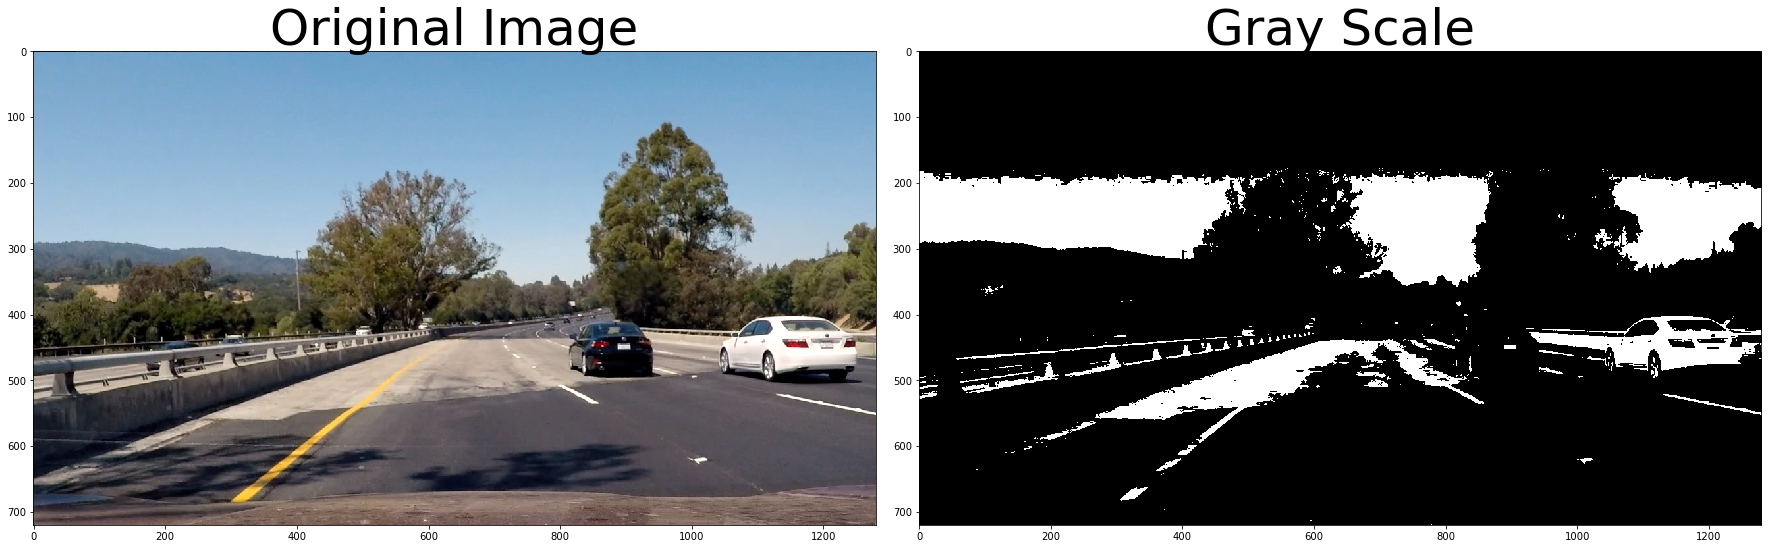

In [62]:
image = mpimg.imread('test_images/test4.jpg')
thresh = (180, 255)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(binary, cmap="gray")
ax2.set_title('Gray Scale', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



# RGB Space

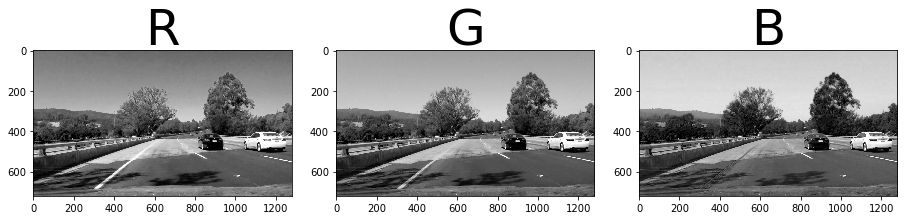

In [63]:
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(12, 9))
f.tight_layout()
ax1.imshow(R,cmap="gray")
ax1.set_title('R', fontsize=50)
ax2.imshow(G,cmap="gray")
ax2.set_title('G', fontsize=50)
ax3.imshow(B,cmap="gray")
ax3.set_title('B', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)




## Aplying a Threshold to R Channel 

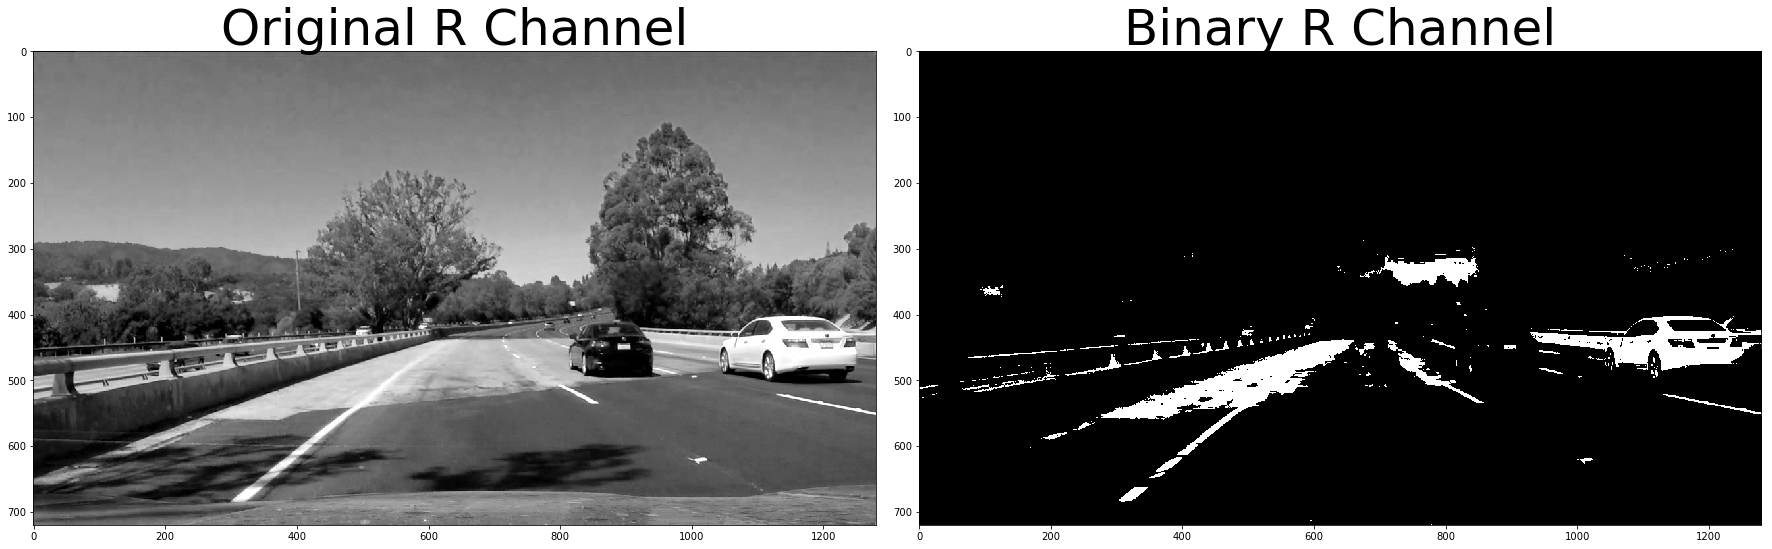

In [70]:
thresh = (200, 255)
binary = np.zeros_like(R)
binary[(R > thresh[0]) & (R <= thresh[1])] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(R,cmap="gray")
ax1.set_title('Original R Channel', fontsize=50)
ax2.imshow(binary, cmap="gray")
ax2.set_title('Binary R Channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# HLS Space

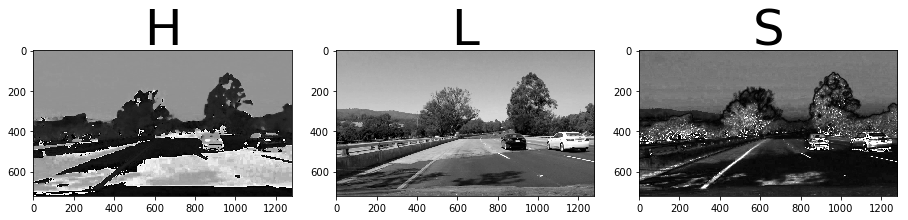

In [65]:
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(12, 9))
f.tight_layout()
ax1.imshow(H,cmap="gray")
ax1.set_title('H', fontsize=50)
ax2.imshow(L,cmap="gray")
ax2.set_title('L', fontsize=50)
ax3.imshow(S,cmap="gray")
ax3.set_title('S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Aplying Threshold to S Channel

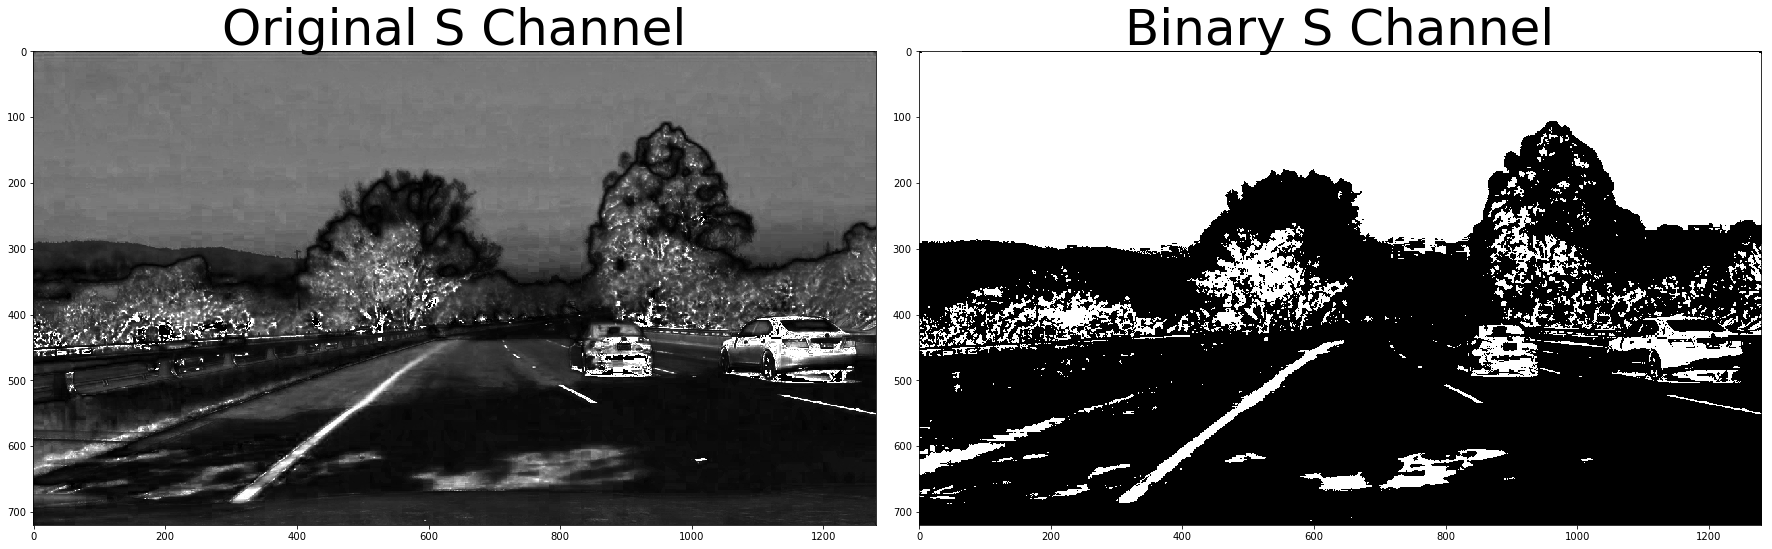

In [66]:
thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(S,cmap="gray")
ax1.set_title('Original S Channel', fontsize=50)
ax2.imshow(binary, cmap="gray")
ax2.set_title('Binary S Channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



# Aplying Threshold to H Channel

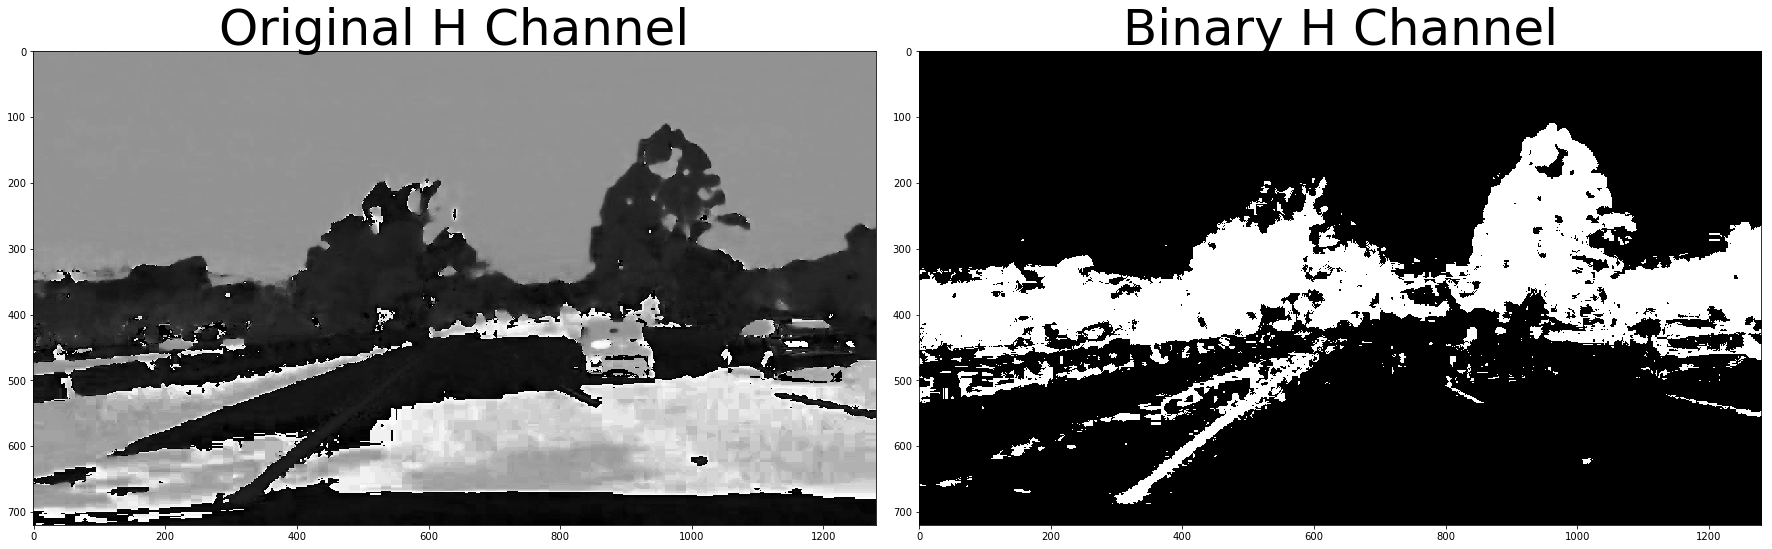

In [67]:
thresh = (15, 100)
binary = np.zeros_like(H)
binary[(H > thresh[0]) & (H <= thresh[1])] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(H,cmap="gray")
ax1.set_title('Original H Channel', fontsize=50)
ax2.imshow(binary, cmap="gray")
ax2.set_title('Binary H Channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



Combining Color and Gradient


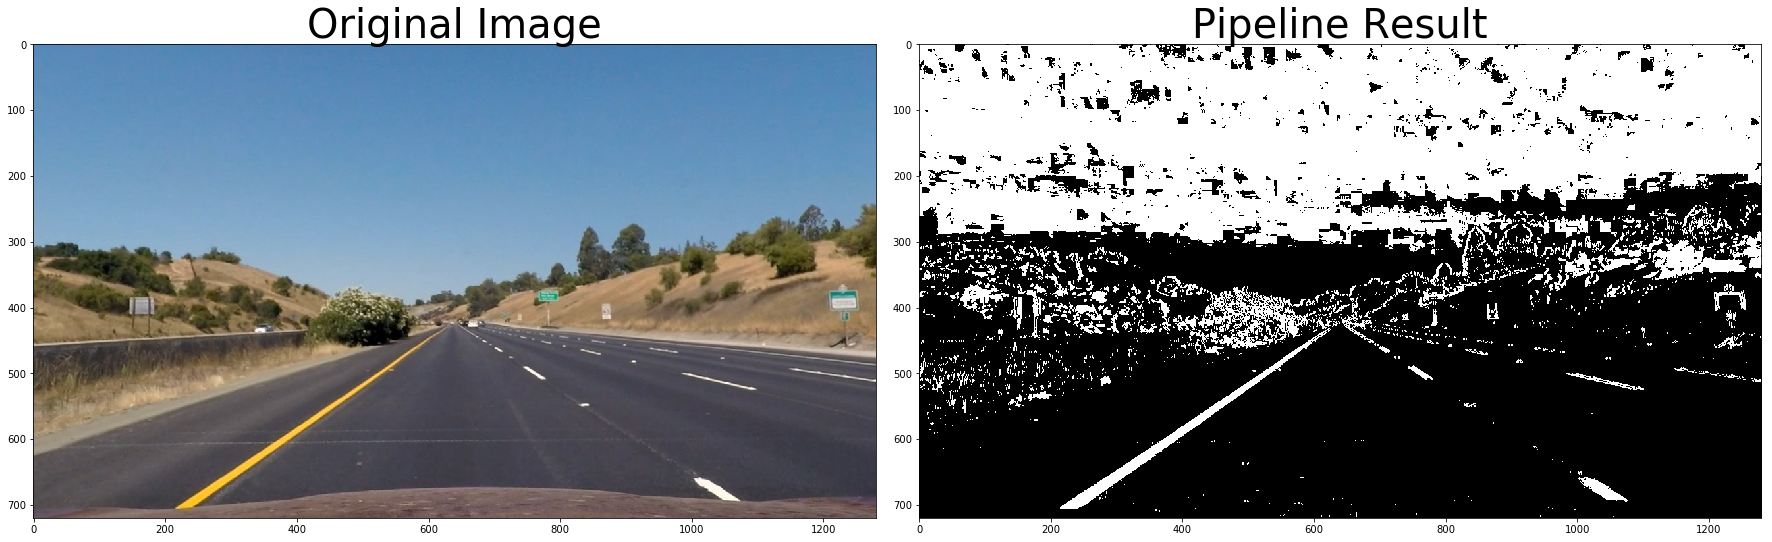

In [150]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image = mpimg.imread('test_images/straight_lines1.jpg')
image = undist(image)

def bird_view (img):
    
    img_size=(img.shape[1],img.shape[0])
    src_pts = np.float32([[245,720],[590,450],[685,450],[1060,720]])
    dst_pts = np.float32([[245,720],[170,0],[1060,0],[1040,720]])
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    bird_view_image = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    
    return bird_view_image


def color_gradient (img):  
    
    
    #### HLS Space Transform and S Threshold 
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= 100) & (s_channel <= 255)] = 1
    
    '''### R Channel Threshold 
    r_channel = img[:,:,0]
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= 30 ) & (r_channel <= 100)] = 1'''
    
    
    sobel_binary = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=150)
    mag_binary = mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255))
    
    
    
    
    combined_binary = (sobel_binary | s_binary)
    
    return combined_binary

result = color_gradient(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap="gray")
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

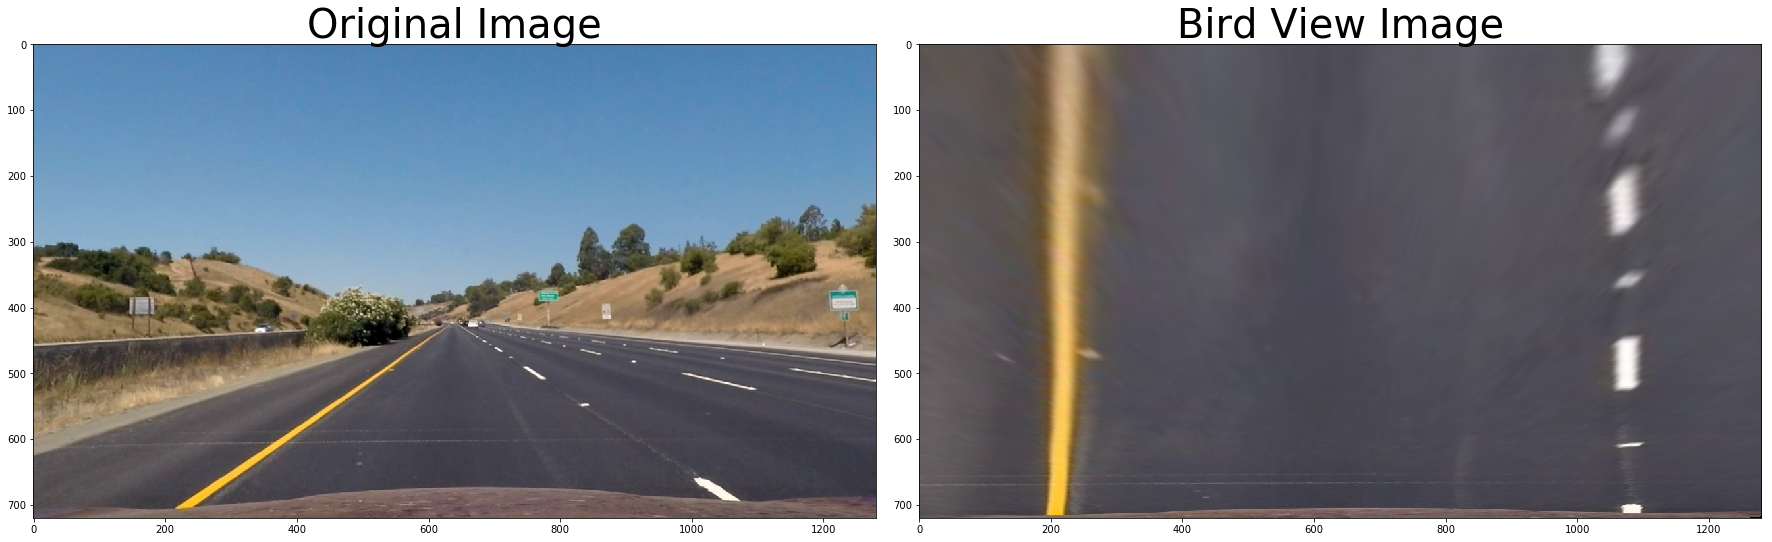

In [151]:
bird_view_image = bird_view(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(bird_view_image, cmap="gray")
ax2.set_title('Bird View Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)